<a href="https://colab.research.google.com/github/KrishnanandSingh/EVA/blob/master/Project-7/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA: Assignment 7

### Import Libraries and modules

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras.layers import Activation, Dropout, Lambda
from keras.layers import Input, Conv2D, concatenate, SeparableConv2D, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

### Get the dataset

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


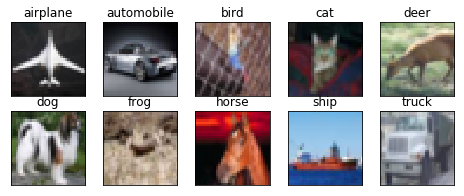

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Define method to plot model history curve after it is trained

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Define method to get validation accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Convert the pixel values to 0,1 and outputs to categorical so that it is easier to train.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### ENAS net

In [10]:
# Define the model

def sep5x5(filters, input, layer_name, padding='valid'):
    layer = SeparableConv2D(filters, (3,3), padding=padding, name='{}_1'.format(layer_name))(input)
    batch_norm = BatchNormalization()(layer)
    relu = Activation('relu', name='{}_relu_1'.format(layer_name))(batch_norm)
    layer = SeparableConv2D(filters, (3,3), padding=padding, name='{}_2'.format(layer_name))(relu)
    batch_norm = BatchNormalization()(layer)
    relu = Activation('relu', name='{}_relu_2'.format(layer_name))(batch_norm)
    return relu

def conv5x5(filters, input, layer_name, padding='valid'):
    layer = Conv2D(filters, (3,3), padding=padding, name='{}_1'.format(layer_name))(input)
    batch_norm = BatchNormalization()(layer)
    relu = Activation('relu', name='{}_relu_1'.format(layer_name))(batch_norm)
    layer = Conv2D(filters, (3,3), padding=padding, name='{}_2'.format(layer_name))(layer)
    batch_norm = BatchNormalization()(layer)
    relu = Activation('relu', name='{}_relu_2'.format(layer_name))(batch_norm)
    return layer

def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2)

def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.
    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])
    
input = Input(shape=(32, 32, 3,))
layer_1 = sep5x5(32, input, 'layer_1', padding='same')
layer_2 = conv5x5(64, layer_1, 'layer_2', padding='same')
layer_3 = conv5x5(64, layer_2, 'layer_3', padding='same')

input_4 = concatenate([layer_1, layer_3])
layer_4 = sep5x5(64, input_4, 'layer_4', padding='same')

input_max_pool_1 = concatenate([layer_4, layer_1])
max_pool_1 = MaxPooling2D(pool_size=(2, 2), name='max_pool_1')(input_max_pool_1)

layer_5 = SeparableConv2D(64, (3,3), name='layer_5', padding='same')(max_pool_1)
batch_norm = BatchNormalization()(layer_5)
layer_5 = Activation('relu', name='{}_relu'.format('layer_5'))(batch_norm)
layer_4_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_4')(layer_4)

input_layer_6 = concatenate([layer_5, layer_4_reshaped])
layer_6 = conv5x5(64, input_layer_6, 'layer_6', padding='same')

layer_3_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_3')(layer_3)
input_layer_7 = concatenate([layer_6, layer_3_reshaped, layer_4_reshaped, layer_5])
layer_7 = SeparableConv2D(64, (3,3), name='layer_7', padding='same')(input_layer_7)
batch_norm = BatchNormalization()(layer_7)
layer_7 = Activation('relu', name='{}_relu'.format('layer_7'))(batch_norm)

input_layer_8 = concatenate([layer_7, layer_3_reshaped, layer_4_reshaped, layer_5, layer_6])
layer_8 = sep5x5(64, input_layer_8, 'layer_8', padding='same')

input_max_pool_2 = concatenate([layer_8, layer_4_reshaped, layer_5, layer_7, layer_8])
max_pool_2 = MaxPooling2D(pool_size=(2, 2), name='max_pool_2')(input_max_pool_2)

layer_6_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_6')(layer_6)
input_layer_9 = concatenate([max_pool_2, layer_6_reshaped])
layer_9 = conv5x5(64, input_layer_9, 'layer_9', padding='same')

layer_2_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_2')(layer_2)
layer_2_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_2_again')(layer_2_reshaped)
layer_7_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_7')(layer_7)
layer_4_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_4_again')(layer_4_reshaped)
input_layer_10 = concatenate([layer_9, layer_2_reshaped, layer_4_reshaped, layer_7_reshaped])
layer_10 = sep5x5(64, input_layer_10, 'layer_10', padding='same')

layer_3_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_3_again')(layer_3_reshaped)
layer_5_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth_layer_5')(layer_5)
input_layer_11 = concatenate([layer_10, layer_2_reshaped, layer_3_reshaped, layer_5_reshaped, layer_9])
layer_11 = Conv2D(64, (3,3), name='layer_11', padding='same')(input_layer_11)

input_layer_12 = concatenate([layer_11, layer_3_reshaped, layer_4_reshaped, layer_5_reshaped, layer_7_reshaped, layer_10])
layer_12 = sep5x5(64, input_layer_12, 'layer_12', padding='same')

concatenated = concatenate([layer_12, layer_4_reshaped, layer_7_reshaped, layer_10])
last_conv = Conv2D(10, (8,8), name='layer_13')(concatenated)

input_output = GlobalAveragePooling2D()(last_conv)

output = Activation('softmax', name='output')(input_output)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0617 08:37:28.547127 140652029372288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 08:37:28.588259 140652029372288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 08:37:28.598014 140652029372288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 08:37:28.650159 140652029372288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 08:37:28.651277 1406520293

### Visualise it

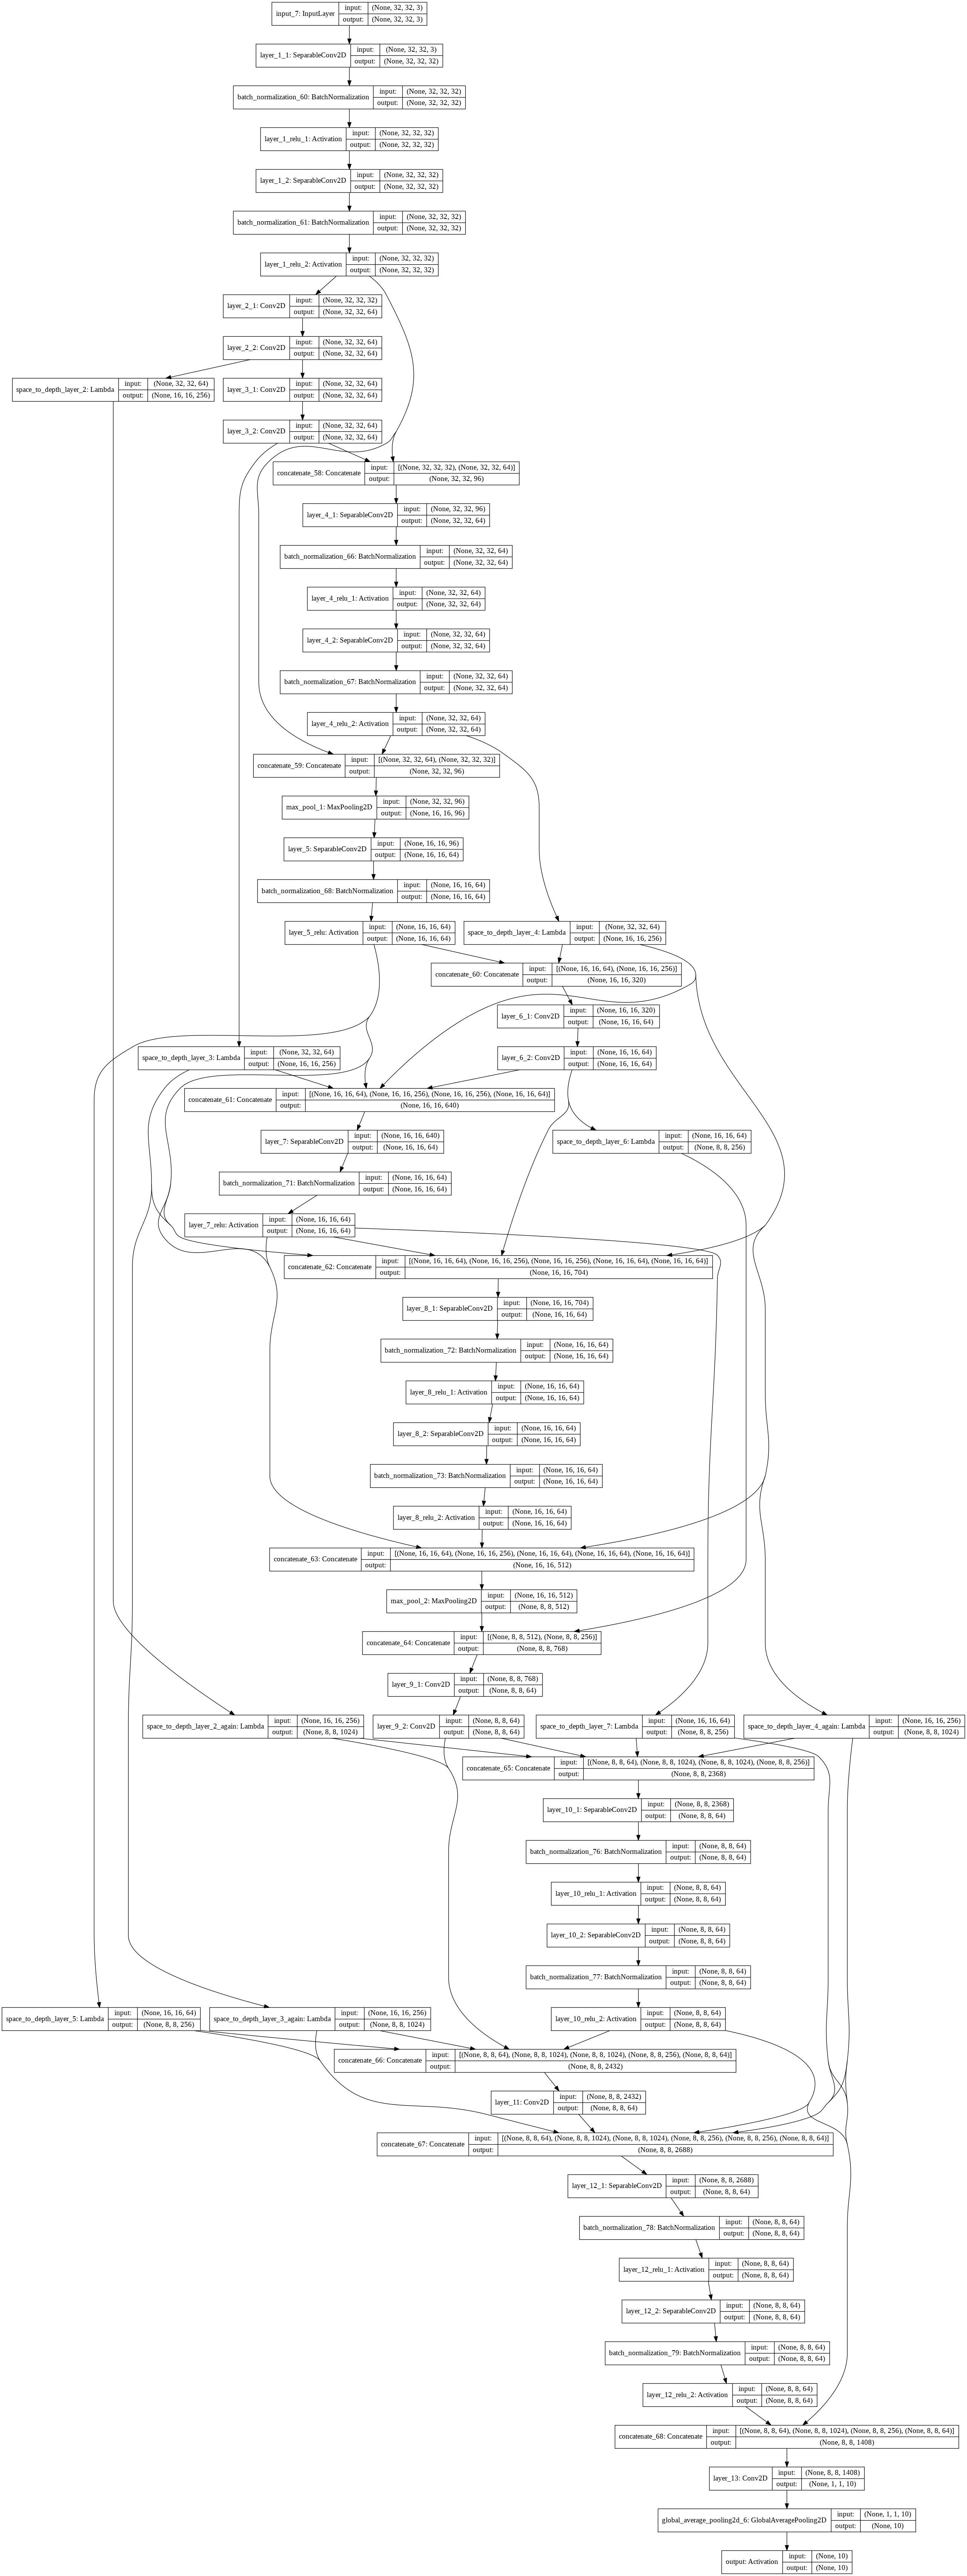

In [0]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_plot.png')

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer_1_1 (SeparableConv2D)     (None, 32, 32, 32)   155         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 32, 32, 32)   128         layer_1_1[0][0]                  
__________________________________________________________________________________________________
layer_1_relu_1 (Activation)     (None, 32, 32, 32)   0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
layer_1_2 

### Train for 100 epochs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  del sys.path[0]
W0617 08:37:37.057666 140652029372288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed

Epoch 1/100
390/390 [==============================] - 65s 167ms/step - loss: 4.2113 - acc: 0.2647 - val_loss: 3.0540 - val_acc: 0.2526
Epoch 2/100
390/390 [==============================] - 60s 154ms/step - loss: 2.6296 - acc: 0.3726 - val_loss: 6.1459 - val_acc: 0.2112
Epoch 3/100
390/390 [==============================] - 60s 154ms/step - loss: 2.3793 - acc: 0.3967 - val_loss: 2.1399 - val_acc: 0.4063
Epoch 4/100
390/390 [==============================] - 60s 153ms/step - loss: 2.2503 - acc: 0.4128 - val_loss: 1.9843 - val_acc: 0.4271
Epoch 5/100
390/390 [==============================] - 60s 153ms/step - loss: 2.3088 - acc: 0.4018 - val_loss: 1.7242 - val_acc: 0.4413
Epoch 6/100
390/390 [==============================] - 60s 154ms/step - loss: 2.0130 - acc: 0.4246 - val_loss: 2.1076 - val_acc: 0.4027
Epoch 7/100
390/390 [==============================] - 60s 153ms/step - loss: 1.8334 - acc: 0.4629 - val_loss: 1.7035 - val_acc: 0.4929
Epoch 8/100
390/390 [===========================

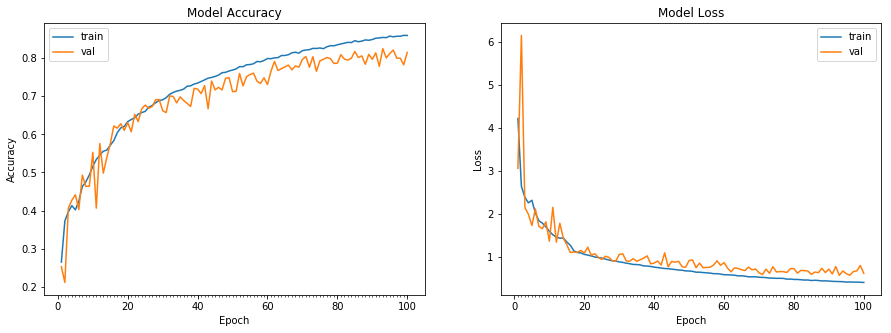

Accuracy on test data is: 81.52


In [11]:
# using simple data augmentation
datagen = ImageDataGenerator(zoom_range=0.1, 
                             horizontal_flip=True,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))